### imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time

from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten

from sklearn.utils import shuffle

### import images

In [39]:
# record start time
start_time = time.time()

x_train = []
y_train = []
x_test = []
y_test = []

# loop through folders
for folder_path in ['chest_xray/train/NORMAL','chest_xray/train/PNEUMONIA','chest_xray/test/NORMAL','chest_xray/test/PNEUMONIA']:
    
    
    # loop through first 200 images
    for filename in os.listdir(folder_path)[:200]:
        
        # read image as a grayscale
        img = cv2.imread(folder_path+'/'+filename, cv2.IMREAD_GRAYSCALE)
        
 
        # resize image to 300x300
        resized = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA) / 255
        
        # normal: 0. pneumonia: 1
        if 'NORMAL' in folder_path:
            label = 0
        else:
            label = 1
        
        
        # if the folder name has "train", then append the image to train data
        if 'train' in folder_path:
            x_train.append(resized)
            y_train.append(label)
            
        # if the folder name has "test", then append the image to train data
        elif 'test' in folder_path:
            x_test.append(resized)
            y_test.append(label)
        
#         counter += 1
#         if counter == 200:
#             break
            
time.time() - start_time

10.80311632156372

In [40]:
# confirming image size is as expected
x_train[0].shape

(300, 300)

In [41]:
# convert list type to numpy array
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# convert each image into a 1-D vector
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)

In [42]:
# confirming data size
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((400, 90000), (400, 90000), (400,), (400,))

### Run a ridge classifier on the data

In [43]:
model = RidgeClassifier()

model.fit(x_train, y_train)

pred = model.predict(x_test)

In [44]:
print(f"accuracy: {(y_test == pred).mean()}")

accuracy: 0.6875


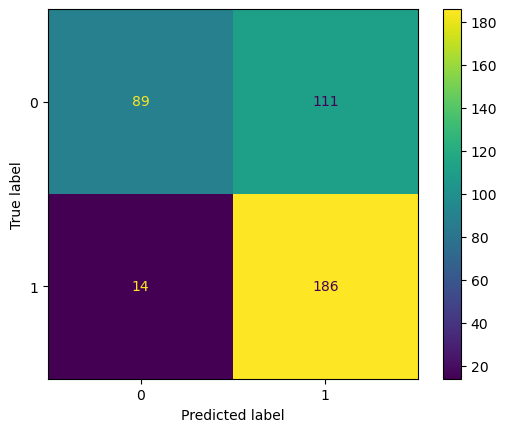

In [45]:
cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                   display_labels=[0,1])
disp.plot()
plt.show()

In [46]:
# save the coefficient values
coef = model.coef_

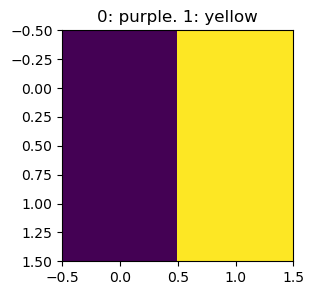

In [47]:
plt.figure(figsize=(3,3))
plt.imshow([[0,1],
            [0,1]])

plt.title('0: purple. 1: yellow')
plt.show()

the above image is just a legend to keep in mind for the below image

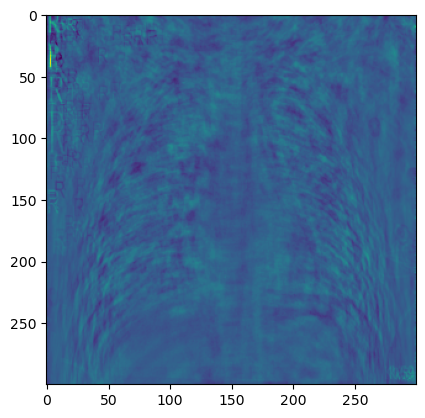

In [48]:
# plot the coeficients of the classifier
plt.imshow(coef.reshape(300,300))
plt.show()

if we look at the above image, it seems in the top left of the image that the letter R is encoded in the coefficients of the classifier

-----------------------  
below, we'll multiply the coefficients with a couple of images. The brighter parts of the image are what is causing the classifier to predict pnemonia.

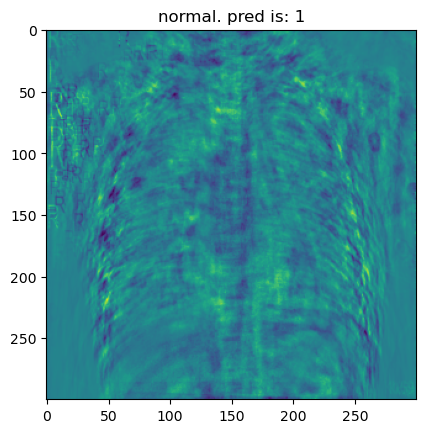

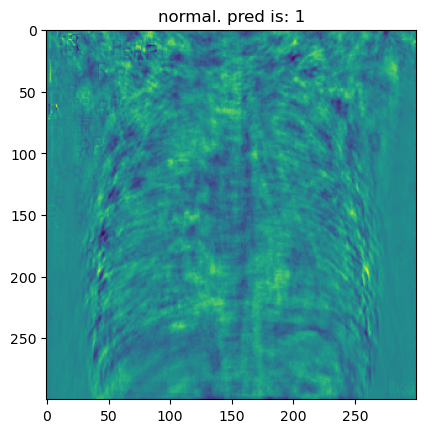

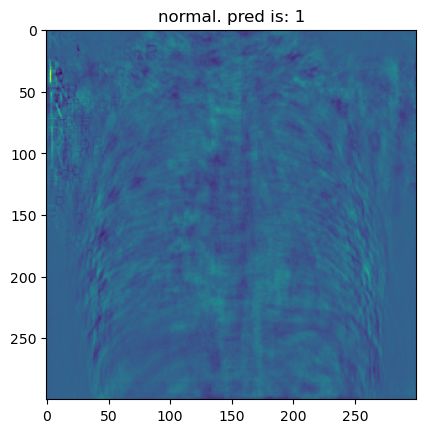

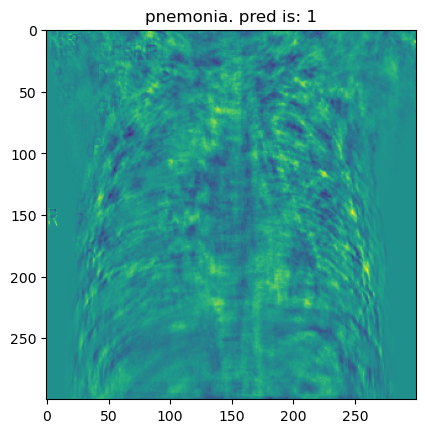

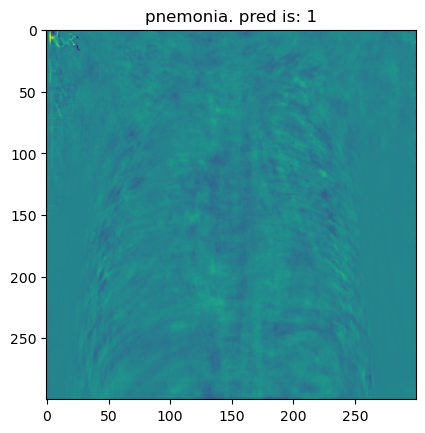

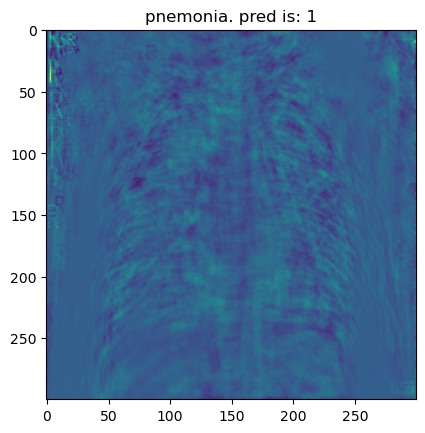

In [58]:
# loop through labels 0 & 1
for i in [0,1]:
    
    # get 3 images and the predictions for the 3 images
    samples = x_test[y_test==i][:3]
    sample_preds = pred[y_test==i][:3]
    
    # loop through the 3 images
    for p, sample in zip(sample_preds, samples):
        
        # multiply the coeficients with the predictions
        t = (sample*coef)
        
        # reshape to square array for plotting
        t = t.reshape(300,300)    
        
        # plot images
        plt.imshow(t)
        
        # set title
        if i==0:
            plt.title(f'normal. pred is: {p}')
        else:
            plt.title(f'pnemonia. pred is: {p}')
        
        plt.show()


### fit data into conv net

In [69]:
x_train = x_train.reshape(-1,300,300)
x_test = x_test.reshape(-1,300,300)

In [70]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((400, 300, 300), (400, 300, 300), (400,), (400,))

In [71]:
x_train, y_train = shuffle(x_train, y_train)

In [72]:
model=Sequential()
#adding convolution layer
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(300,300,1)))
#adding pooling layer
model.add(MaxPool2D(2,2))
#adding fully connected layer
model.add(Flatten())
model.add(Dense(100,activation='relu'))
#adding output layer
model.add(Dense(1,activation='sigmoid'))
#compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#fitting the model
model.fit(x_train,y_train,epochs=4, batch_size=20)

Epoch 1/4
20/20 [==============================] - 12s 584ms/step - loss: 8.8854 - accuracy: 0.5450
Epoch 2/4
20/20 [==============================] - 11s 559ms/step - loss: 0.6968 - accuracy: 0.4950
Epoch 3/4
20/20 [==============================] - 11s 563ms/step - loss: 0.6932 - accuracy: 0.4750
Epoch 4/4
20/20 [==============================] - 12s 588ms/step - loss: 0.6932 - accuracy: 0.4500


In [73]:
pred = model.predict(x_test)
pred = pred.reshape(-1) > 0.5

In [74]:
print(f"accuracy: {(pred == y_test).mean()}")

accuracy: 0.5


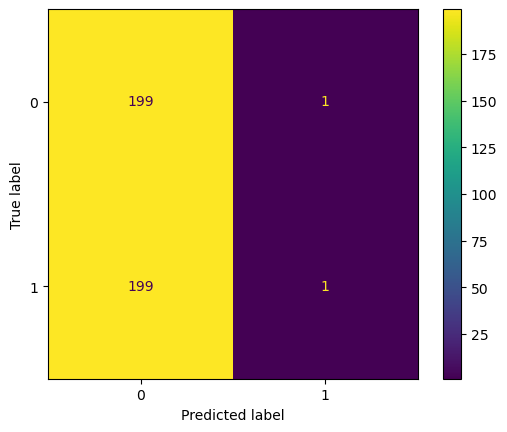

In [75]:
cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                   display_labels=[0,1])
disp.plot()
plt.show()